# Метрика для оценки разницы между спектрограммами

In [1]:
import sys
sys.path.append('..')

from functools import reduce

import numpy as np
from scipy import signal

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot

from utils import get_cv, draw_modifications_dist, get_modifications_list

### Процедура получения метрики

**Расстояние между двумя спектрограммами** с равным количеством трасс и отсчетов будем вычислять по следующей процедуре

* Выбрать область из 10% трасс с наименьшим офсетом, ограничить вычисления только в этой области
* Получить спектральную плотность мощности с помощью оконного преобразования Фурье для каждой трассы для обеих спектрограмм
* Для соответствующих значений сдвигов окна по времени и соответсвующих трасс вычислить разницу спектров в разных спектрограммах по формуле
$$
Dist(A_1, A_2) = \sum_{f}\left|{A_{1}[f]-A_{2}[f]}\right|
$$
* Усреднить полученные значения по всем трассам и всем сдвигам окна по времени

![Seismogram difference metrics](Seismogram_difference_metrics.png)

# Синтетический шум

In [2]:
!ls ~/winhome/datasets/synthtics3/

geo05_computedReflection_i.sgy	geo_05_noise.sgy	 модель.JPG
geo05_computedReflection.sgy	geo_05_velocity.7z	 трасса.jpg
geo_05_full.sgy			geo_07_SurWaveNoise.sgy


In [3]:
base_path = '/home/antonina/winhome/datasets/synthtics3/'
      
paths = dict(ideal = 'geo05_computedReflection_i.sgy',
             noise = 'geo_07_SurWaveNoise.sgy',)


## Загружаем и изучаем данные 

In [4]:
field_index = reduce(lambda x, y: x.merge(y),
                     (FieldIndex(name=p, path=base_path+paths[p], extra_headers=['offset']) for p in paths))

len(field_index)

1

In [5]:
field_index._idf['offset'] = field_index._idf['offset'].abs()
field_index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,ideal,ideal,noise,noise
FieldRecord,,,,,,
1,1000,1,1,/home/antonina/winhome/datasets/synthtics3/geo...,1,/home/antonina/winhome/datasets/synthtics3/geo...
1,975,2,2,/home/antonina/winhome/datasets/synthtics3/geo...,2,/home/antonina/winhome/datasets/synthtics3/geo...
1,950,3,3,/home/antonina/winhome/datasets/synthtics3/geo...,3,/home/antonina/winhome/datasets/synthtics3/geo...
1,925,4,4,/home/antonina/winhome/datasets/synthtics3/geo...,4,/home/antonina/winhome/datasets/synthtics3/geo...
1,900,5,5,/home/antonina/winhome/datasets/synthtics3/geo...,5,/home/antonina/winhome/datasets/synthtics3/geo...


In [6]:
components = tuple(paths.keys())
batch = (Dataset(field_index, SeismicBatch).next_batch(1)
         .load(fmt='segy', components=components)
         .sort_traces(src=components, dst=components, sort_by='offset'))

In [7]:
ideal, noise = batch.ideal[0], batch.noise[0]
cv = get_cv([ideal])
cv

21.293914794921875

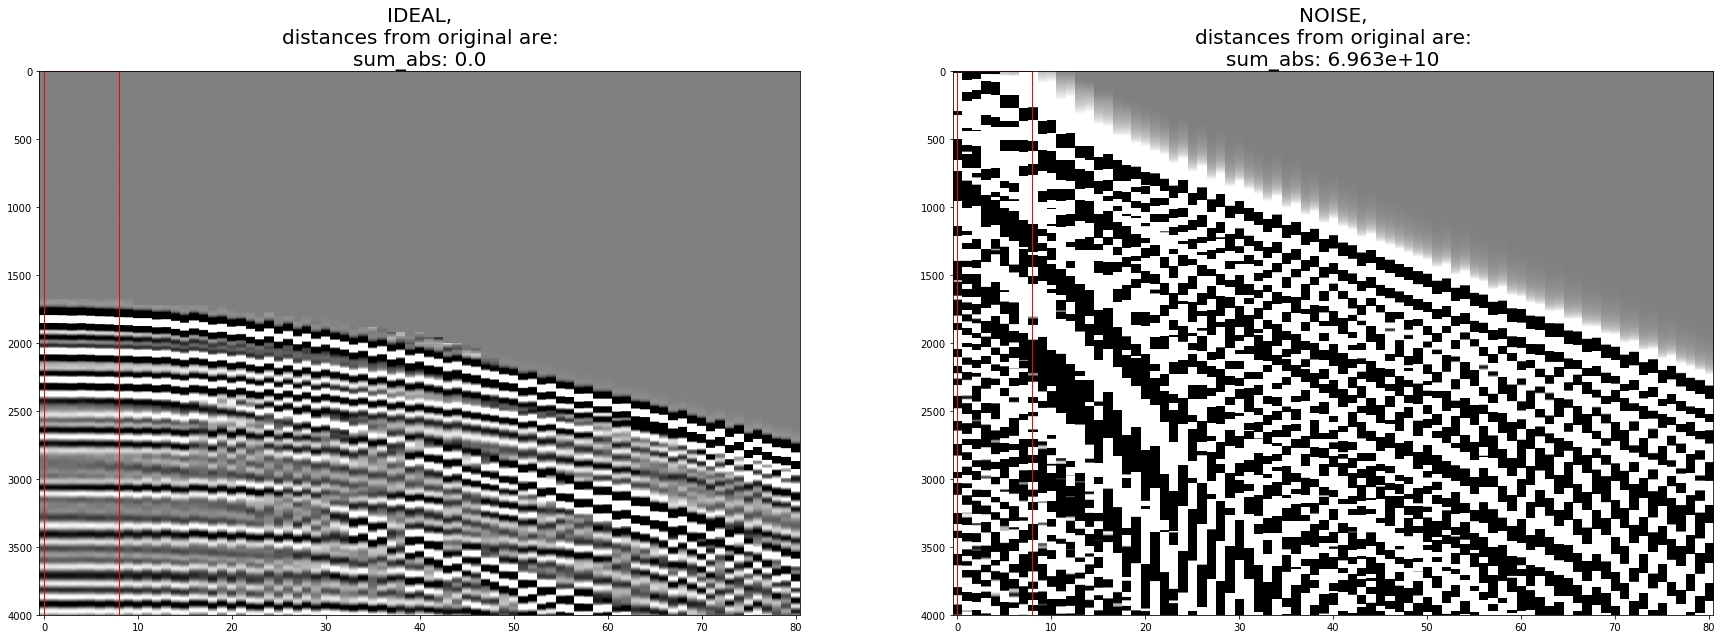

In [8]:
draw_modifications_dist(get_modifications_list(batch, 0), vmin=-cv, vmax=cv,  figsize=(30, 10), aspect='auto')

5271.6875


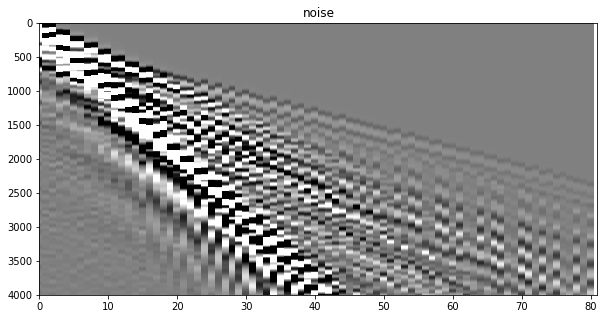

In [9]:
cv_n = get_cv([noise])
print(cv_n)
seismic_plot((noise,), names=('noise',),  figsize=(10, 5), vmin=-cv_n, vmax=cv_n, cmap='gray')

# нормируем сейсмограмму шума т.о., чтобы 95% амплитуд были меньше 1

In [10]:
noise_n = noise/cv_n

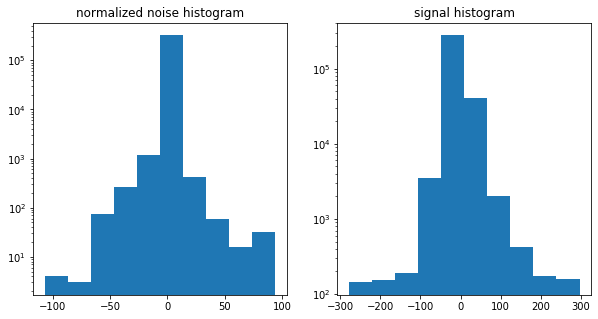

In [11]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1,2, figsize=(10, 5))

axs[0].hist(noise_n.flatten())
axs[0].set_yscale('log')
axs[0].set_title('normalized noise histogram')

axs[1].hist((ideal).flatten())
axs[1].set_yscale('log')
axs[1].set_title('signal histogram');

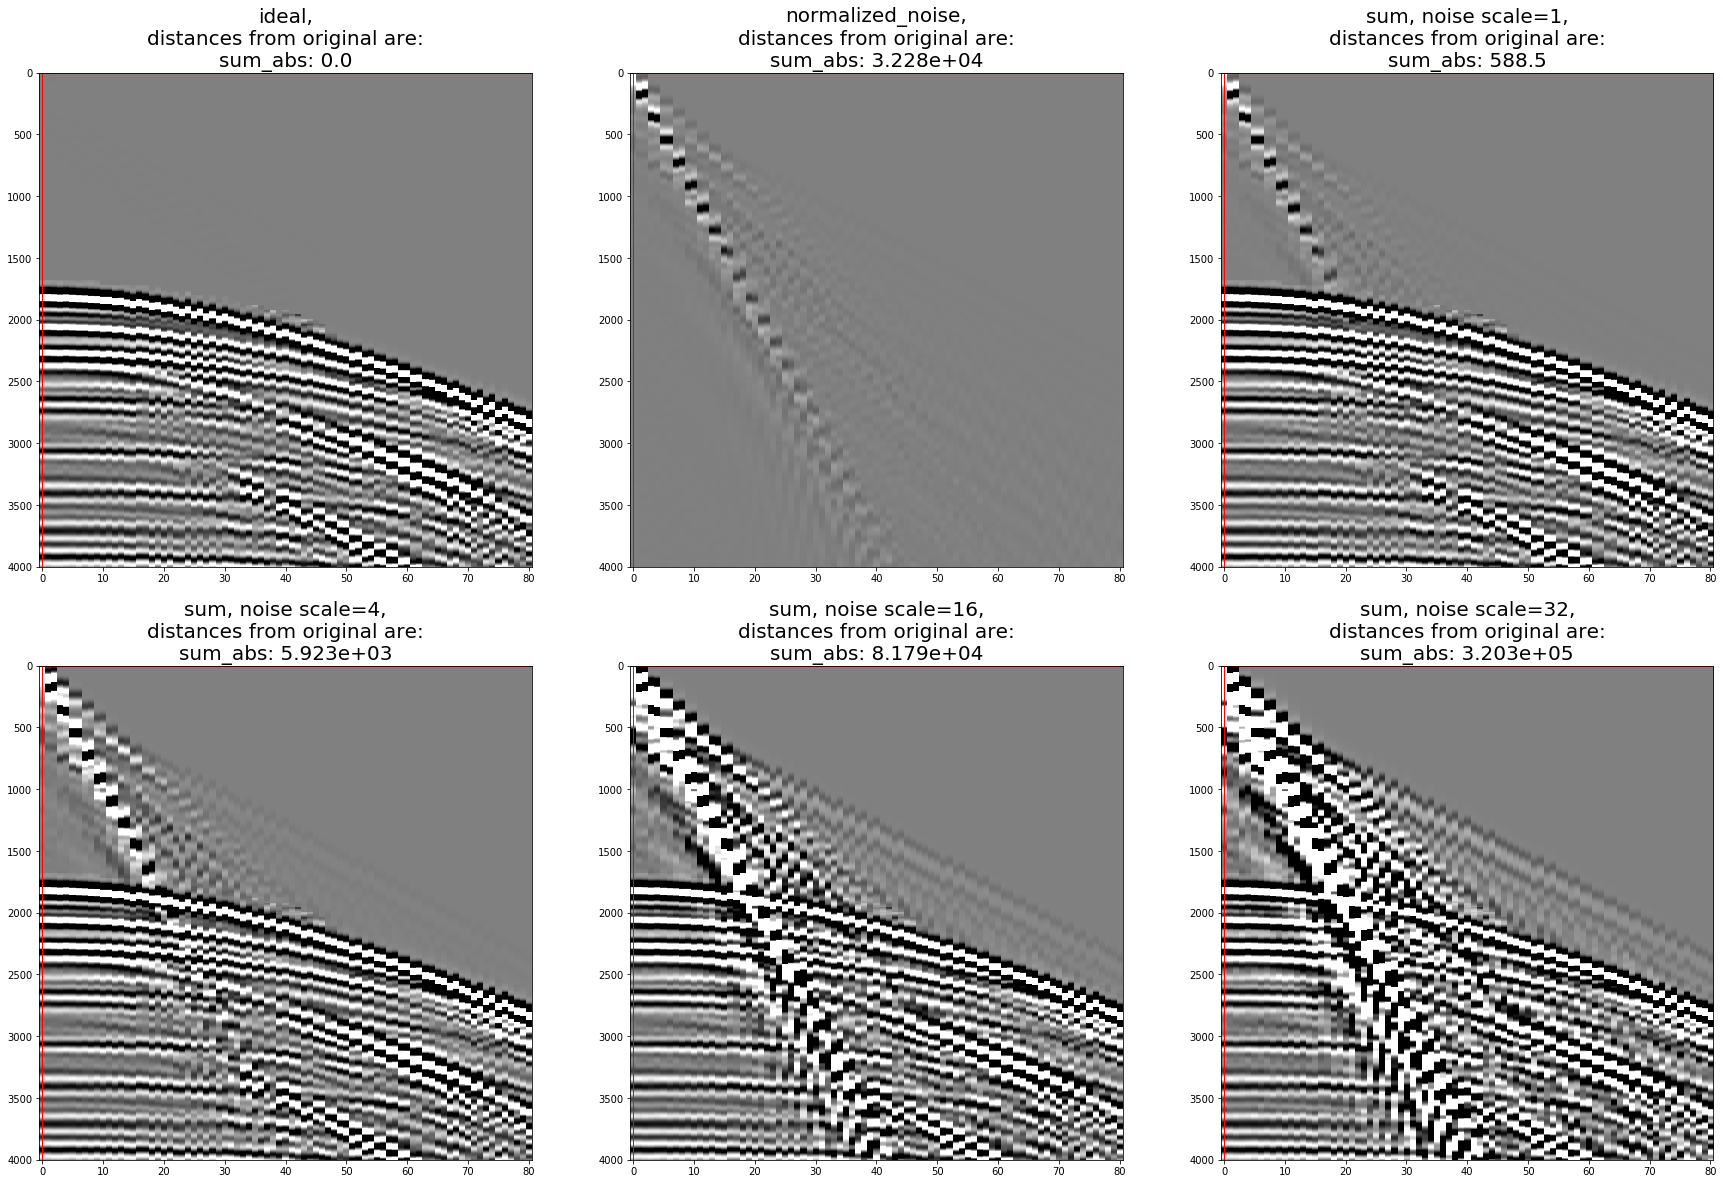

In [12]:
mods = [(ideal, 'ideal'), (noise_n, 'normalized_noise')]

for i in (1, 4, 16, 32):
    mods.append((ideal + noise_n * i, "sum, noise scale={}".format(i)))


draw_modifications_dist(mods, traces_frac=1, vmin=-cv, vmax=cv,  figsize=(30, 20), n_cols=3, aspect='auto')

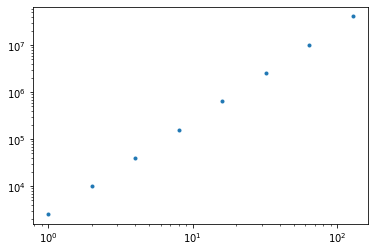

In [13]:
from utils import get_windowed_spectrogram_dists
def plot_scales(origin, noise, scales, 
                traces_frac=0.1, dist_fn='sum_abs', 
                time_frame_width=100, noverlap=None, window=('tukey', 0.25), do_plot=True):
    
    n_traces, n_ts = origin.shape
    n_use_traces = int(n_traces*traces_frac)
    
    dist = []
    
    for s in scales:
        mod = origin + noise * s
        dist_m = get_windowed_spectrogram_dists(mod[0:n_use_traces], origin[0:n_use_traces], dist_fn=dist_fn,
                                                time_frame_width=time_frame_width, noverlap=noverlap, window=window)
        dist.append(np.mean(dist_m))
            
    if do_plot:
        plt.plot(scales, dist, '.')
        plt.yscale('log')
        plt.xscale('log')
    
    return np.array(dist)
    
d1 = plot_scales(ideal, noise_n, (0, 1, 2, 4, 8, 16, 32, 64, 128))